In [1]:
#собираем данные для обучения
import pandas as pd
df_dolly = pd.read_csv('./create_data/deepseek_databricks_600.csv')
df_dolly['context'] = [''] * len(df_dolly)
df_dolly = df_dolly[['instruction', 'context', 'predicted_label']]

df_alpaca = pd.read_csv('./create_data/deepseek_alpaca_3000.csv')
df_alpaca = df_alpaca[['instruction', 'context', 'predicted_label']]

df_alpaca_code = pd.read_csv('./create_data/deepseek_code_alpaca_2000.csv')
df_alpaca_code = df_alpaca_code[['instruction', 'context', 'predicted_label']]

df_roleplay = pd.read_csv('./create_data/deepseek_roleplay_3000.csv')
df_roleplay = df_roleplay[['instruction', 'context', 'predicted_label']]

df_medical = pd.read_csv('./create_data/deepseek_medical_1500.csv')
df_medical['context'] = [''] * len(df_medical)
df_medical = df_medical[['instruction', 'context', 'predicted_label']]

df_oasst = pd.read_csv('./create_data/deepseek_oasst_3000.csv')
df_oasst['context'] = [''] * len(df_oasst)
df_oasst = df_oasst[['instruction', 'context', 'predicted_label']]

result_df = pd.concat([df_dolly, df_alpaca, df_alpaca_code, df_roleplay, df_medical, df_oasst], ignore_index=True)
result_df = result_df[result_df['predicted_label'] != -1]

result_df['predicted_label'] = [0 if i == 1 else 1 for i in result_df['predicted_label'].astype(int).to_list()]
result_df.to_csv('./train_data_deepseek_dolly_alpaca_code_roleplay_medical_oasst.csv', index=False)

In [2]:
result_df['predicted_label'].value_counts()

predicted_label
1    9954
0    3130
Name: count, dtype: int64

In [3]:
balanced_df = pd.DataFrame()
class_0 = result_df[result_df['predicted_label'] == 0]
class_1 = result_df[result_df['predicted_label'] == 1]

class_1_balanced = class_1.sample(n=len(class_0), random_state=42)
balanced_df = pd.concat([class_0, class_1_balanced], ignore_index=True)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df.to_csv('./train_data_last.csv', index=False)

In [4]:
balanced_df

,instruction,context,predicted_label
0,Were the languages in Tolkien's Lord of the ri...,,0
1,*I take a sip of my drink and shake my head* O...,NaN,1
2,Create a list comprehension that finds all ele...,"numbers =[1, 5, 8, 10, 15, 20]",1
3,why do you think it is okay to shot down the m...,,0
4,How do I create a database dump for a running ...,,0
...,...,...,...
6255,"*I chuckle, feeling a little embarrassed.* It’...",NaN,1
6256,"*You grip your own weapon, preparing for the f...",NaN,1
6257,"*I take a step back, not liking the intense lo...",NaN,1
6258,"*You approach the Zen Master, feeling curious ...",NaN,1


In [5]:
result_df['predicted_label'].value_counts()


predicted_label
1    9954
0    3130
Name: count, dtype: int64

In [1]:
import numpy as np
from datasets import load_dataset, Dataset, concatenate_datasets
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


dataset = load_dataset('csv', data_files='./dataset_balanced.csv')

# Разделение на train и validation
dataset = dataset['train'].shuffle(seed=42).train_test_split(test_size=0.1, seed=42)

# Загрузим предобученную модель и токенизатор
model_name = "distilbert/distilbert-base-uncased"#"FacebookAI/xlm-roberta-large"##
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to('cuda')

def tokenize_function(examples, order='context_first'):
    if order == 'context_first':
        texts = [str(context) + ' ' + str(instruction) 
                for context, instruction in zip(examples["context"], examples["instruction"])]
    else:
        texts = [str(instruction) + ' ' + str(context) 
                for context, instruction in zip(examples["context"], examples["instruction"])]
    
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512
    )
    
    result = {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": [i for i in examples["predicted_label"]]
    }
    
    return result

# Токенизируем данные в двух вариантах
tokenized_train_context_first = dataset['train'].map(
    lambda x: tokenize_function(x, 'context_first'), 
    batched=True
)
tokenized_train_instruction_first = dataset['train'].map(
    lambda x: tokenize_function(x, 'instruction_first'), 
    batched=True
)

tokenized_val_context_first = dataset['test'].map(
    lambda x: tokenize_function(x, 'context_first'), 
    batched=True
)
tokenized_val_instruction_first = dataset['test'].map(
    lambda x: tokenize_function(x, 'instruction_first'), 
    batched=True
)

# Объединяем наборы данных
tokenized_train = concatenate_datasets([tokenized_train_context_first, tokenized_train_instruction_first])
tokenized_val = concatenate_datasets([tokenized_val_context_first, tokenized_val_instruction_first])

tokenized_train = tokenized_train.shuffle(seed=42)
tokenized_val = tokenized_val.shuffle(seed=42)
tokenized_train = tokenized_train_instruction_first
tokenized_val = tokenized_val_instruction_first


#Настройка параметров обучения
training_args = TrainingArguments(
    output_dir="./distilbert2",
    learning_rate=1e-5,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",       
    #eval_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    fp16=True,
    gradient_accumulation_steps=4,
    lr_scheduler_type="linear",
    optim="adamw_torch"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Инициализация тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

# Обучение модели
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5634 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.641500,0.394526,0.835463,0.850000,0.831804,0.840804
2,0.322400,0.440017,0.838658,0.895105,0.782875,0.835237
3,0.309100,0.462874,0.830671,0.844237,0.828746,0.836420


KeyboardInterrupt: 

In [11]:
model.save_pretrained('./distilbert/checkpoint')

In [2]:
tokenizer.save_pretrained('./distilbert/checkpoint-705')

('./distilbert/checkpoint-705\\tokenizer_config.json',
 './distilbert/checkpoint-705\\special_tokens_map.json',
 './distilbert/checkpoint-705\\vocab.txt',
 './distilbert/checkpoint-705\\added_tokens.json',
 './distilbert/checkpoint-705\\tokenizer.json')

In [9]:
tokenizer.save_pretrained('./distilbert/checkpoint-705')

('./distilbert/checkpoint-705\\tokenizer_config.json',
 './distilbert/checkpoint-705\\special_tokens_map.json',
 './distilbert/checkpoint-705\\vocab.txt',
 './distilbert/checkpoint-705\\added_tokens.json',
 './distilbert/checkpoint-705\\tokenizer.json')

In [3]:
# Пример использования модели для предсказания
def predict_query(text, threshold=0.5):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        needs_search = probabilities[0][1].item() > threshold
    return needs_search


Метрики для разных порогов уверенности:
   confidence_threshold  coverage  accuracy  precision  recall     f1  \
0                  0.50     1.000     0.845      0.866   0.832  0.849   
1                  0.60     0.930     0.869      0.882   0.865  0.873   
2                  0.65     0.895     0.870      0.884   0.863  0.873   
3                  0.70     0.866     0.876      0.891   0.869  0.880   
4                  0.75     0.792     0.889      0.891   0.895  0.893   
5                  0.80     0.728     0.906      0.902   0.921  0.911   
6                  0.85     0.634     0.917      0.915   0.936  0.925   
7                  0.90     0.508     0.928      0.932   0.947  0.939   
8                  0.95     0.187     0.940      0.963   0.952  0.958   
9                  0.99     0.000     0.000      0.000   0.000  0.000   

   samples_count  
0            626  
1            582  
2            560  
3            542  
4            496  
5            456  
6            397  
7  

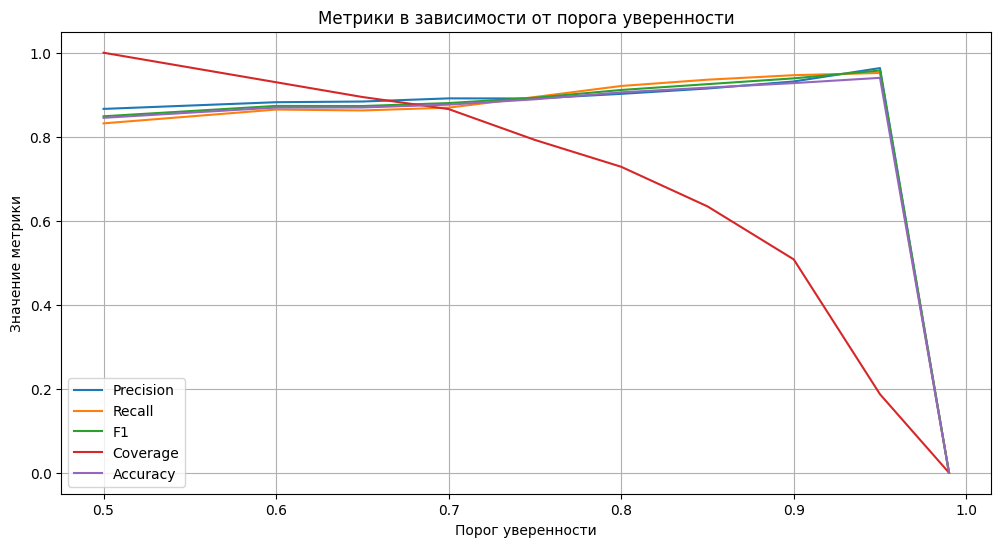

In [3]:
# Получаем предсказания модели для validation set
import pandas as pd
from matplotlib import pyplot as plt
model.eval()
all_predictions = []
all_probabilities = []

# Обрабатываем данные батчами
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for i in range(0, len(tokenized_val), batch_size):
        batch = tokenized_val[i:i + batch_size]
        inputs = {
            'input_ids': torch.tensor(batch['input_ids']).to(device),
            'attention_mask': torch.tensor(batch['attention_mask']).to(device)
        }
        
        outputs = model(**inputs)
        logits = outputs.logits
        
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

predicted_labels = np.array(all_predictions)
probabilities = np.array(all_probabilities)
confidences = np.max(probabilities, axis=1)

# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'true_label': tokenized_val['labels'],
    'predicted_label': predicted_labels,
    'confidence': confidences
})

def evaluate_model_with_confidence(results_df, confidence_threshold=0.95):
    # Фильтруем результаты по порогу уверенности
    filtered_results = results_df[results_df['confidence'] >= confidence_threshold]
    
    # Базовые метрики
    true_positives = sum((filtered_results['true_label'] == 1) & (filtered_results['predicted_label'] == 1))
    false_positives = sum((filtered_results['true_label'] == 0) & (filtered_results['predicted_label'] == 1))
    false_negatives = sum((filtered_results['true_label'] == 1) & (filtered_results['predicted_label'] == 0))
    
    # Добавляем подсчет accuracy
    accuracy = sum(filtered_results['true_label'] == filtered_results['predicted_label']) / len(filtered_results) if len(filtered_results) > 0 else 0
    
    # Расчет остальных метрик
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Количество примеров, прошедших порог уверенности
    coverage = len(filtered_results) / len(results_df)
    
    return {
        'confidence_threshold': confidence_threshold,
        'coverage': coverage,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'samples_count': len(filtered_results)
    }

# Оценка метрик для разных порогов уверенности
thresholds = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
metrics = []

for threshold in thresholds:
    metrics.append(evaluate_model_with_confidence(results_df, threshold))

# Создаем DataFrame с результатами
metrics_df = pd.DataFrame(metrics)
print("\nМетрики для разных порогов уверенности:")
print(metrics_df.round(3))

# Обновляем график с добавлением accuracy
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['confidence_threshold'], metrics_df['precision'], label='Precision')
plt.plot(metrics_df['confidence_threshold'], metrics_df['recall'], label='Recall')
plt.plot(metrics_df['confidence_threshold'], metrics_df['f1'], label='F1')
plt.plot(metrics_df['confidence_threshold'], metrics_df['coverage'], label='Coverage')
plt.plot(metrics_df['confidence_threshold'], metrics_df['accuracy'], label='Accuracy')

plt.xlabel('Порог уверенности')
plt.ylabel('Значение метрики')
plt.title('Метрики в зависимости от порога уверенности')
plt.legend()
plt.grid(True)
plt.show()

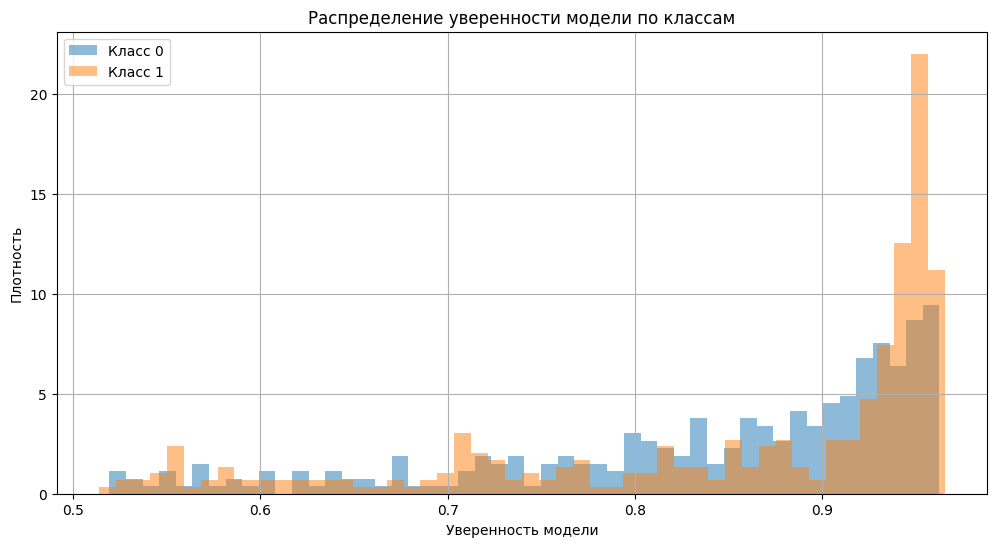


Статистика уверенности по классам:

Класс 0:
count    299.000
mean       0.841
std        0.115
min        0.519
25%        0.783
50%        0.880
75%        0.930
max        0.963
Name: confidence, dtype: float64

Класс 1:
count    327.000
mean       0.856
std        0.127
min        0.514
25%        0.778
50%        0.925
75%        0.950
max        0.966
Name: confidence, dtype: float64


In [4]:
# Разделяем данные по истинным классам
class_0_conf = results_df[results_df['true_label'] == 0]['confidence']
class_1_conf = results_df[results_df['true_label'] == 1]['confidence']

# Создаем график распределения уверенности для каждого класса
plt.figure(figsize=(12, 6))

# Гистограмма для обоих классов
plt.hist(class_0_conf, bins=50, alpha=0.5, label='Класс 0', density=True)
plt.hist(class_1_conf, bins=50, alpha=0.5, label='Класс 1', density=True)

plt.xlabel('Уверенность модели')
plt.ylabel('Плотность')
plt.title('Распределение уверенности модели по классам')
plt.legend()
plt.grid(True)
plt.show()

# Выводим базовую статистику
print("\nСтатистика уверенности по классам:")
print("\nКласс 0:")
print(class_0_conf.describe().round(3))
print("\nКласс 1:")
print(class_1_conf.describe().round(3))

In [5]:
# Пример использования модели для предсказания
def predict_query(text, threshold=0.9):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.softmax(outputs.logits, dim=1)
        print(probabilities)
        needs_search = probabilities[0][1].item() > threshold
    return needs_search

print(predict_query('To be, or not to be, that is the question." Please translate this sentence into French.', threshold=0.9))
print(predict_query('Dave is attending his aunts brother funeral today." Paraphrase the given information effectively', threshold=0.9))
print(predict_query('Please find a novel that is as famous as "One Hundred Years of Solitude', threshold=0.9))
print(predict_query('ChatGPT is a product of OpenAI." Please provide the ownership relationship', threshold=0.9))
print(predict_query('"French.Washington played a crucial role in the American Revolutionary War, leading the Continental Army against the British. " Please continue writing the above paragraph.', threshold=0.9))
print(predict_query('Q: 3,1 A: 3 Q: 2,5 A: 5 Q: 5,7 A: ?', threshold=0.9))
print(predict_query('Please give me a plan for holding a graduation party. ', threshold=0.9))
print(predict_query('Which city will the next World Cup be held? ', threshold=0.9))
print(predict_query('If you are currently a computer science student and your computer system encounters a malfunction, what should you do? ', threshold=0.9))

tensor([[0.0892, 0.9108]], device='cuda:0')
True
tensor([[0.0959, 0.9041]], device='cuda:0')
True
tensor([[0.4427, 0.5573]], device='cuda:0')
False
tensor([[0.5323, 0.4677]], device='cuda:0')
False
tensor([[0.5375, 0.4625]], device='cuda:0')
False
tensor([[0.2801, 0.7199]], device='cuda:0')
False
tensor([[0.0804, 0.9196]], device='cuda:0')
True
tensor([[0.8482, 0.1518]], device='cuda:0')
False
tensor([[0.3937, 0.6063]], device='cuda:0')
False
